# Algoritmus 2D Szenzor optimális pozíciójára

Vegyünk egy 2D hőtérképet kiindulásképpen.

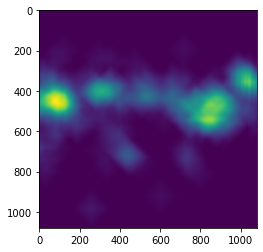

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
from scipy import ndimage as ndi
from scipy.stats import mode
from skimage.feature import peak_local_max
from tqdm import tqdm
from place_me import optimize_v2, optimize_v3

data = np.loadtxt('data/heatmap2.txt')
data = 255 * data / data.max()
data = data[:, 2760:3840]
plt.imshow(data);

A hőtérképen kiválasztunk $n$ darab lokális maximum helyet, amelyen elhelyezünk $R$ sugarú köröket, ahol $n$ és $R$ az adott környezethez választott. (Példa: $n$-t az alkalmazást használó személyek számából kapjuk, $R$-t pedig úgy választjuk, hogy a valóságbeli mérete nagyjából az emberi kézzel azonos legyen). A hőtérkép nem determinisztikus, hanem valószínűségi jellegű, vagyis a generált körök pontos pozíciója ingadozik: a hőtérképen nagyobb értéken nagyobb valószínűséggel tartózkodik. A körök nem fedhetnek egymásba. Az alábbi kép egy $n = 6$ és $R = 40\,pixel$ felállást mutat.

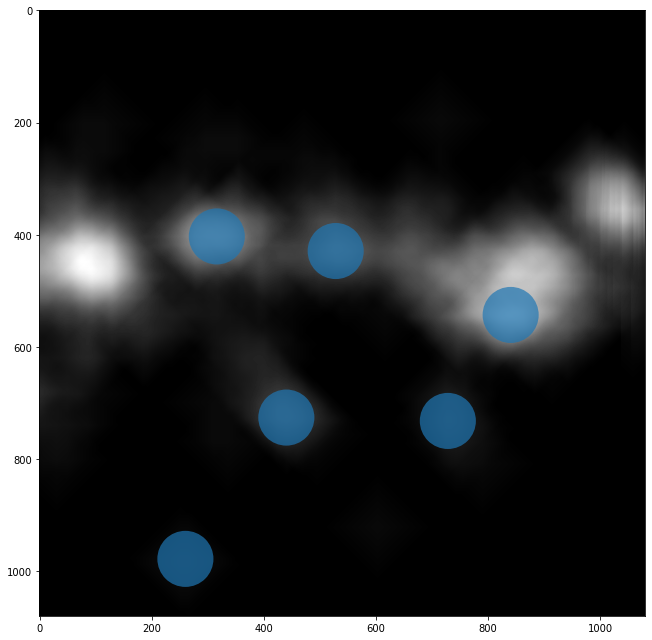

In [11]:
CIRCLE_RADIUS = 50

image_max = ndi.maximum_filter(data, size=20, mode='constant')

peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=6)

def plot_from_optimal_coords(data, peaks, arr=None):
    fig, ax = plt.subplots(figsize=(10, 9))
    ax.imshow(data, cmap=plt.cm.gray)
    ax.autoscale(False)
    if arr is not None:
        [x1, y1, x2, y2,  x3, y3] = arr
        ax.plot(x1, y1, 'yx', markersize=25, markeredgewidth=3)
        ax.plot(x2, y2, 'rx', markersize=25, markeredgewidth=3)
        if x3 is not None:
            ax.plot(x3, y3, 'bx', markersize=25, markeredgewidth=3)

    for y, x in peaks:
        circ = Circle((x, y), CIRCLE_RADIUS, alpha=0.7)
        ax.add_patch(circ)

    fig.tight_layout()

    plt.show()

plot_from_optimal_coords(data, peaks)

Minden szenzor a hőtérkép kerülete mentén mozoghat. Egy szenzor esetén a lefedettséget úgy definiáljuk, hogy:
  - a lehető legtöbb kört lássuk
  - a körökből látott kerület szeletek összege a lehető legnagyobb


Újabb szenzorok hozzáadásánál egy adott körnél a már korábban lefedett területeket nem vesszük figyelembe - mivel ez nem hordoz új információt. A folyamat az, hogy addig adunk hozzá új szenzorokat, amíg minden kör látható legalább egy szenzor számára. A valószínűségi jelleg miatt ezt a szimulációt kellően sokszor futtatva megkapjuk, hogy mik lesznek az optimális szenzor pozíciók.

Legyen $L(x) = 1$ ha $x > 0$, különben $0$, ún. egységugrás függvény, továbbá legyen egy adott $i$ objektum belátott része $L_{i} = \frac{\sum látott\,kerület}{2\pi R}$. Ekkor $n$ darab objektum esetén az $LF$ teljes lefedettséget a következőképpen definiáljuk:
<center>
$LF = \sum_{i=1}^{n} (L(x_i) + L_i(x))$
</center>




A lentebbi ábrák ezzel a súlyfüggvénnyel számolt szimulációk eseteit mutatják, ahol piros és sárga markerek mutatják az optimális szenzor pozíciókat. Az alábbi példában 200-szor futtatjuk le a teljes szimulációt kissé különböző pozíciójú körökön, majd a KDE plotról a maximum értéket választjuk pozícióként, és azt ábrázoljuk. (**Note: Biztos, hogy ez helyes?**). 

In [3]:
%env RUST_LOG=0

NUM_OF_SIM = 50
r = np.array([])

for i in tqdm(range(NUM_OF_SIM)):
    peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=6)
    peaks = peaks + np.random.normal(0, CIRCLE_RADIUS / 4, size=peaks.shape)
    arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
    options = {
        'width': data.shape[1],
        'height': data.shape[0],
        'resolution': 500,
        'pixel_step': 20,
    }
    res = optimize_v2(*arr.T, **options)
    r = np.append(r, res)



env: RUST_LOG=0


100%|███████████████████████████████████████████| 50/50 [00:14<00:00,  3.42it/s]


In [4]:
res = np.array(np.array_split(r, NUM_OF_SIM))

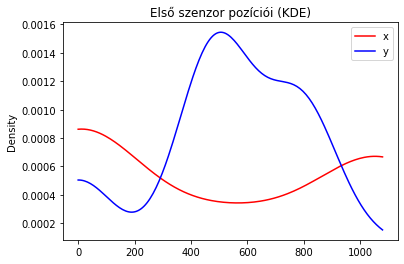

In [5]:
# First sensor
sns.kdeplot(res[:,0], color='red', cut=0, label="x")
sns.kdeplot(res[:,1], color='blue', cut=0, label="y")
plt.title("Első szenzor pozíciói (KDE)")
plt.legend();

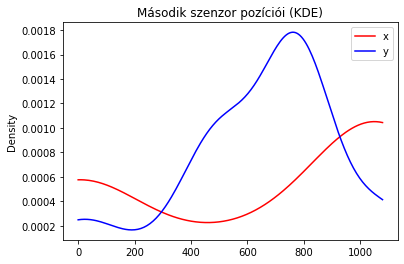

In [6]:
# Second sensor
sns.kdeplot(res[:,2], color='red', cut=0, label="x")
sns.kdeplot(res[:,3], color='blue', cut=0, label="y")
plt.title("Második szenzor pozíciói (KDE)")
plt.legend();

In [7]:
x1 = mode(res[:,0])
y1 = mode(res[:,1])
x2 = mode(res[:,2])
y2 = mode(res[:,3])

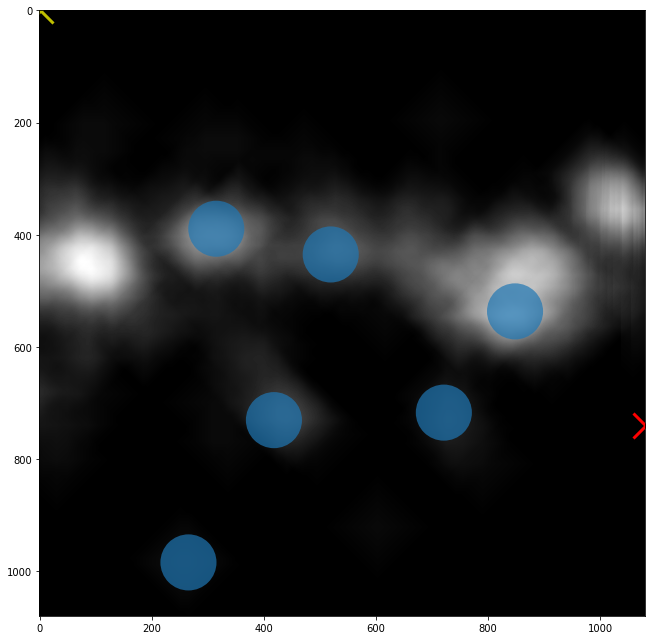

In [8]:
plot_from_optimal_coords(data, peaks, [x1.mode[0], y1.mode[0], x2.mode[0], y2.mode[0], None, None])

#### Szimuláció három szenzorral:

env: RUST_LOG=1

🎯 covered 97.35528036805711% (11.682633644166852/12)
optimal positions [
    Point {
        x: 0.0,
        y: 460.0,
    },
    Point {
        x: 960.0,
        y: 0.0,
    },
    Point {
        x: 880.0,
        y: 1080.0,
    },
]


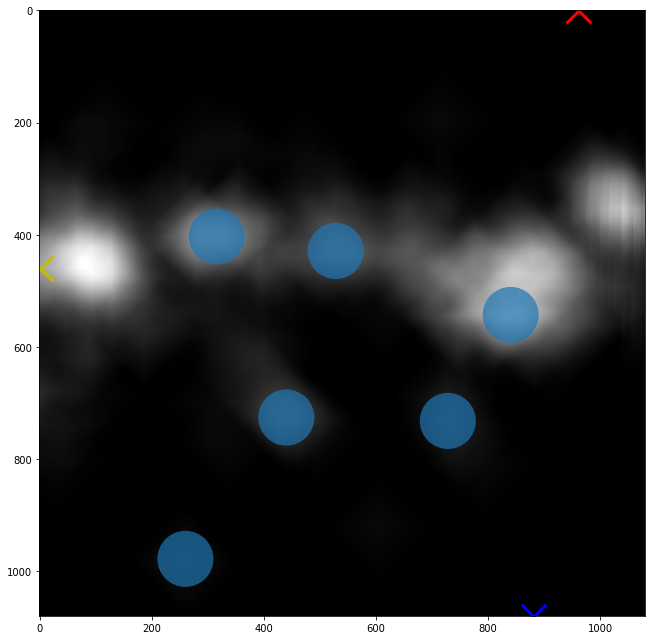

CPU times: user 36min 59s, sys: 9.45 s, total: 37min 8s
Wall time: 3min 20s


In [12]:
%%time
%env RUST_LOG=1

peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=6)
arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
options = {
    'width': data.shape[1],
    'height': data.shape[0],
    'resolution': 2280,
    'pixel_step': 20,
}
res = optimize_v3(*arr.T, **options)
plot_from_optimal_coords(data, peaks, res)

### Számolási részletek

Legyen egy $r$ sugarú kör $O(O_x, O_y)$ középponttal, továbbá tekintsünk két $P(P_x, P_y)$ pontból kiinduló sugarat, amelyek $P_1(P_{1x}, P_{1y})$ és $P_2(P_{2x}, P_{2y})$ pontokban metszik a kört (ha több metszéspont is lehetséges, akkor a közelebbit választjuk). Legyen a metszéspontoknál lévő két szög $\alpha_1$ és $\alpha_2$ standard x-y koordinátarendszerben, amelyek egyszerűen számolhatóak az $atan2(P_{iy} - O_y, P_{ix} - O_x)$ formulával. 

A szimuláció során minden körhöz hozzá van rendelve egy állapot, amely tárolja, hogy mely szögtartományokban van lefedve. Ezek összefedő részei egy adott szenzorállásnál egyesítésre kerülnek, aztán a fennmaradó intervallumok hosszát kiszámolva, majd $2\pi$-vel elosztva megkapjuk, hogy az adott kör hányad része lefedett, vagyis ez adja a fentebb említett $L_i(x)$ függvényt.